In [1]:
from __future__ import print_function, division, absolute_import
from six.moves import cPickle as pickle

In [2]:
import os, time

import numpy as np

import tensorflow as tf

/usr/local/lib/python3.5/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [3]:
from matplotlib import pyplot as plt
%matplotlib inline

### Loading the data

In [4]:
image_size = 28
pixel_depth = 255
data_root = 'data'

In [5]:
pickle_file  = os.path.join(data_root, 'notMNIST.pickle')
keys = ["{0}_{1}".format(t,x) for t in ["train","test"] for x in "Xy"]+["labels_dict"]
with open(pickle_file, 'rb') as f:
    pi = pickle.load(f)
    for k in keys:
        globals()[k] = pi[k]
print(train_X.shape, test_X.shape)

(529114, 784) (18724, 784)


In [6]:
nclasses = len(labels_dict)
labels_dict

{'A': 0,
 'B': 1,
 'C': 2,
 'D': 3,
 'E': 4,
 'F': 5,
 'G': 6,
 'H': 7,
 'I': 8,
 'J': 9}

In [7]:
def to_onehot(labels, nclasses):
    onehot = np.zeros(shape=(len(labels), nclasses))
    for i, label in enumerate(labels):
        onehot[i, int(label)] = 1
    return onehot

test_y = to_onehot(test_y, nclasses)

In [8]:
def generate_batch(batch_size=10):
    global train_X, train_y, labels_dict
    j = 0
    while 1:
        i = j
        if i+batch_size < len(train_X):
            j = i + batch_size
            raw_labels = train_y[i:i+batch_size]
            yield train_X[i:i+batch_size], to_onehot(raw_labels.flatten(), len(labels_dict))
        else:
            j = 0
            raw_labels = np.concatenate((train_y[i:], train_y[0:batch_size-(len(train_y)-i)]))
            yield np.concatenate((train_X[i:], train_X[0:batch_size-(len(train_X)-i)])),\
                    to_onehot(raw_labels.flatten(), len(labels_dict))
        

In [9]:
img_size = 28
in_depth = 1  # gray scale
out_depth = 16
kernel_size = 5
hsize = 64
batch_size = 1000

In [10]:
train_X = train_X.reshape((train_X.shape[0], img_size, img_size, in_depth))
train_X.shape

(529114, 28, 28, 1)

In [11]:
test_X = test_X.reshape((test_X.shape[0], img_size, img_size, in_depth))
test_X.shape

(18724, 28, 28, 1)

## Inception Module
### Concatenation

In [12]:
graph = tf.Graph()

with graph.as_default():
    with tf.name_scope("inputs"):
        train_inputs = tf.placeholder(tf.float32, shape=[batch_size, image_size,image_size, in_depth])
        train_labels = tf.placeholder(tf.int32, shape=[batch_size, nclasses])
        beta = tf.placeholder("float")
        alpha = tf.placeholder("float")
    with tf.name_scope("Weights"):
        one_one_filter = tf.Variable(
            tf.truncated_normal([1, 1, in_depth, out_depth],stddev=0.1)
        )
        one_one_b = tf.Variable(
            tf.zeros([out_depth])
        )
        
        
        three_three_filter = tf.Variable(
            tf.truncated_normal([3, 3, out_depth, out_depth],stddev=0.1)
        )
        three_three_b = tf.Variable(
            tf.zeros([out_depth])
        )
        
        
        five_five_filter = tf.Variable(
            tf.truncated_normal([5, 5, out_depth, out_depth],stddev=0.1)
        )
        five_five_b = tf.Variable(
            tf.zeros([out_depth])
        )

        
        pooling_filter = tf.Variable(
            tf.truncated_normal([kernel_size, kernel_size, in_depth, out_depth],stddev=0.1)
        )
        p_b = tf.Variable(
            tf.zeros([out_depth])
        )
        
        padding = 0
        strides = 2
        l_w = tf.Variable(
            tf.truncated_normal([(((img_size - 1 - 2*padding)//strides) + 1)**2*16*2 + img_size**2*2, hsize], stddev=0.1)
        )
        l_b = tf.Variable(
            tf.zeros([hsize])
        )
        
        l5_w = tf.Variable(
            tf.truncated_normal([hsize, nclasses],stddev=0.1)
        )
        l5_b = tf.Variable(
            tf.zeros([nclasses])
        )
        
    with tf.name_scope("convulotion"):
        def model(data, keep=0.5):
            conv_one_one = tf.nn.conv2d(data, one_one_filter, [1,2,2,1], padding='SAME')
            
            h1 = tf.nn.relu(conv_one_one+one_one_b)

            conv_three_three = tf.nn.conv2d(h1, three_three_filter, [1,2,2,1], padding='SAME')
            h2 = tf.nn.relu(conv_three_three+three_three_b)
            
            conv_five_five = tf.nn.conv2d(h1, five_five_filter, [1,2,2,1], padding='SAME')
            h3 = tf.nn.relu(conv_five_five+five_five_b)

            pool1 = tf.nn.pool(data, [kernel_size,kernel_size], pooling_type="AVG", padding='SAME')
            p_conv = tf.nn.conv2d(pool1, pooling_filter, [1,2,2,1], padding='SAME')
            h4 = tf.nn.relu(p_conv+p_b)
            
            h1_shape = h1.get_shape().as_list()
            s1 = h1_shape[1]*h1_shape[2]*h1_shape[3]
            h1_reshape = tf.reshape(h1, [tf.shape(h1)[0], s1])

            h2_shape = h2.get_shape().as_list()
            s2 = h2_shape[1]*h2_shape[2]*h2_shape[3]
            h2_reshape = tf.reshape(h2, [tf.shape(h2)[0], s2])

            h3_shape = h3.get_shape().as_list()
            s3 = h3_shape[1]*h3_shape[2]*h3_shape[3]
            h3_reshape = tf.reshape(h3, [tf.shape(h3)[0], s3])

            h4_shape = h4.get_shape().as_list()
            s4 = h4_shape[1]*h4_shape[2]*h4_shape[3]
            h4_reshape = tf.reshape(h4, [tf.shape(h4)[0], s4])
            hidden = tf.concat([h1_reshape,h2_reshape,h3_reshape,h4_reshape], axis=1)
        
            # fullyconnected
            hidden = tf.add(tf.matmul(hidden, l_w), l_b)
            hidden = tf.nn.dropout(tf.nn.relu(hidden), keep)
            logits = tf.add(tf.matmul(hidden, l5_w), l5_b)
            
            return logits
        
    logits = model(train_inputs) 
    
    with tf.name_scope("Loss"):
        cross_entropy_ = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=train_labels))
    
    with tf.name_scope("regularization"):
        regularizer = tf.nn.l2_loss(cross_entropy_)
        cross_entropy = tf.reduce_mean(tf.add(cross_entropy_, tf.multiply(beta,regularizer)))
    
    with tf.name_scope("Optimizer"):
        optimizer = tf.train.GradientDescentOptimizer(alpha).minimize(cross_entropy)
        
    with tf.name_scope("Predictions"):
        test_inputs = tf.placeholder(tf.float32, shape=[None, image_size,image_size, in_depth])
        test_labels = tf.placeholder(tf.int32, shape=[None, nclasses])
        test_logits = model(test_inputs, 1.0)
        prediction_probs = tf.nn.softmax(test_logits)
        predictions = tf.argmax(prediction_probs, 1)
        
    with tf.name_scope("Accuracy"):
        target = tf.argmax(test_labels, 1)
        correct = tf.equal(predictions, target)
        accuracy = tf.reduce_mean(tf.cast(correct, "float"))
    init = tf.global_variables_initializer()
    

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See tf.nn.softmax_cross_entropy_with_logits_v2.



In [13]:
def run_session(graph, epochs, learning_rate, beta_input, batch_size):
    start = time.time()
    accuracies = dict()
    losses = dict()
    batches = generate_batch(batch_size=batch_size)

    with tf.Session(graph=graph) as sess:
        with tf.device("/gpu"):
            init.run()
            print("Variables initialized")
            average_loss = 0
            for e in range(epochs+1):
                batch_X, batch_y = batches.__next__()
                feed_dict = {train_inputs:batch_X, train_labels:batch_y, beta:beta_input,alpha:learning_rate}
                _, loss = sess.run([optimizer, cross_entropy], feed_dict=feed_dict)
                average_loss += np.mean(loss)
#                 if e%50 == 0:
                if e%100 == 0:
                    print("Epoch {0}\nCross-entropy loss: {1}".format(e,average_loss if e>0 else average_loss))
                losses[e] = average_loss
                average_loss = 0
                accuracy_ = sess.run([accuracy], feed_dict={test_inputs:test_X, test_labels:test_y})
                accuracy_ = np.mean(accuracy_)
                accuracies[e] = accuracy_
                if e%100 == 0:
                    print("Accuracy:{0}".format(accuracy_))
                    print("~"*40)
    print("Took: {}".format(time.time()-start))

    fig, ax1 = plt.subplots(figsize=(12,7))
    xticks = sorted(accuracies.keys())
    data1 = [accuracies[i] for i in xticks]
    data2 = [losses[i] for i in xticks]

    color = 'tab:blue'
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Accuracy', color=color)
    ax1.plot(xticks, data1, color=color)
    ax1.tick_params(axis='y', labelcolor=color)

    ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

    color = 'tab:red'
    ax2.set_ylabel('Cross-entropy loss', color=color)
    ax2.plot(xticks, data2, color=color)
    ax2.tick_params(axis='y', labelcolor=color)

    fig.tight_layout()  # otherwise the right y-label is slightly clipped

Variables initialized
Epoch 0
Cross-entropy loss: 2.6598925590515137
Accuracy:0.16422772407531738
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch 100
Cross-entropy loss: 0.01281095266342163
Accuracy:0.8333689570426941
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch 200
Cross-entropy loss: 0.010041894912719727
Accuracy:0.8580965399742126
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch 300
Cross-entropy loss: 0.008452075719833373
Accuracy:0.8660008311271667
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch 400
Cross-entropy loss: 0.008748181462287903
Accuracy:0.8737983107566833
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch 500
Cross-entropy loss: 0.00840841829776764
Accuracy:0.8791390657424927
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch 600
Cross-entropy loss: 0.008453887701034547
Accuracy:0.8817560076713562
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch 700
Cross-entropy loss: 0.008152937889099121
Accuracy:0.8845866322517395
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch 800
Cross-entropy

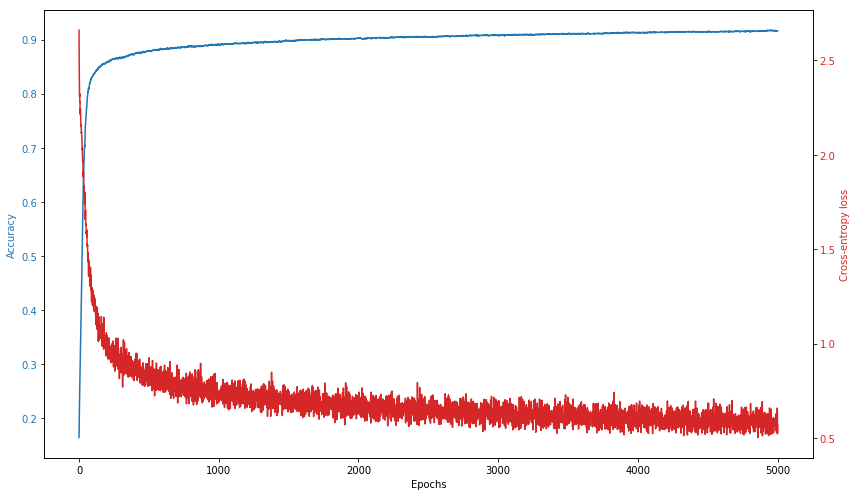

In [14]:
epochs = 5000
learning_rate = 0.03
beta_input = 0.01
batch_size = 1000

run_session(graph, epochs, learning_rate, beta_input, batch_size)

### Mean reduce instead of concatenation

In [15]:
graph = tf.Graph()

with graph.as_default():
    with tf.name_scope("inputs"):
        train_inputs = tf.placeholder(tf.float32, shape=[batch_size, image_size,image_size, in_depth])
        train_labels = tf.placeholder(tf.int32, shape=[batch_size, nclasses])
        beta = tf.placeholder("float")
        alpha = tf.placeholder("float")
    with tf.name_scope("Weights"):
        one_one_filter = tf.Variable(
            tf.truncated_normal([1, 1, in_depth, out_depth],stddev=0.1)
        )
        one_one_b = tf.Variable(
            tf.zeros([out_depth])
        )
        
        
        three_three_filter = tf.Variable(
            tf.truncated_normal([3, 3, out_depth, out_depth],stddev=0.1)
        )
        three_three_b = tf.Variable(
            tf.zeros([out_depth])
        )
        
        
        five_five_filter = tf.Variable(
            tf.truncated_normal([5, 5, out_depth, out_depth],stddev=0.1)
        )
        five_five_b = tf.Variable(
            tf.zeros([out_depth])
        )

        
        pooling_filter = tf.Variable(
            tf.truncated_normal([kernel_size, kernel_size, in_depth, out_depth],stddev=0.1)
        )
        p_b = tf.Variable(
            tf.zeros([out_depth])
        )
        
        l1_w = tf.Variable(
                tf.truncated_normal([img_size*img_size*out_depth//4, hsize],stddev=0.1)
            )
        l1_b = tf.Variable(
            tf.zeros([hsize])
        )

        l2_w = tf.Variable(
            tf.truncated_normal([img_size*img_size, hsize],stddev=0.1)
        )
        l2_b = tf.Variable(
            tf.zeros([hsize])
        )

        l3_w = tf.Variable(
            tf.truncated_normal([img_size*img_size, hsize],stddev=0.1)
        )
        l3_b = tf.Variable(
            tf.zeros([hsize])
        )

        l4_w = tf.Variable(
            tf.truncated_normal([img_size*img_size*out_depth//4, hsize],stddev=0.1)
        )
        l4_b = tf.Variable(
            tf.zeros([hsize])
        )
        
        l5_w = tf.Variable(
            tf.truncated_normal([hsize, nclasses],stddev=0.1)
        )
        l5_b = tf.Variable(
            tf.zeros([nclasses])
        )
        
    with tf.name_scope("convulotion"):
        def model(data, keep=0.5):
            conv_one_one = tf.nn.conv2d(data, one_one_filter, [1,2,2,1], padding='SAME')
            
            h1 = tf.nn.relu(conv_one_one+one_one_b)

            conv_three_three = tf.nn.conv2d(h1, three_three_filter, [1,2,2,1], padding='SAME')
            h2 = tf.nn.relu(conv_three_three+three_three_b)
            
            conv_five_five = tf.nn.conv2d(h1, five_five_filter, [1,2,2,1], padding='SAME')
            h3 = tf.nn.relu(conv_five_five+five_five_b)

            pool1 = tf.nn.pool(data, [kernel_size,kernel_size], pooling_type="AVG", padding='SAME')
            p_conv = tf.nn.conv2d(pool1, pooling_filter, [1,2,2,1], padding='SAME')
            h4 = tf.nn.relu(p_conv+p_b)
            
            h1_shape = h1.get_shape().as_list()
            s1 = h1_shape[1]*h1_shape[2]*h1_shape[3]
            h1_reshape = tf.reshape(h1, [tf.shape(h1)[0], s1])

            h2_shape = h2.get_shape().as_list()
            s2 = h2_shape[1]*h2_shape[2]*h2_shape[3]
            h2_reshape = tf.reshape(h2, [tf.shape(h2)[0], s2])

            h3_shape = h3.get_shape().as_list()
            s3 = h3_shape[1]*h3_shape[2]*h3_shape[3]
            h3_reshape = tf.reshape(h3, [tf.shape(h3)[0], s3])

            h4_shape = h4.get_shape().as_list()
            s4 = h4_shape[1]*h4_shape[2]*h4_shape[3]
            h4_reshape = tf.reshape(h4, [tf.shape(h4)[0], s4])
            hidden = tf.concat([h1_reshape,h2_reshape,h3_reshape,h4_reshape], axis=1)
        
            # fullyconnected
            l1 = tf.add(tf.matmul(h1_reshape, l1_w), l1_b)
            l2 = tf.add(tf.matmul(h2_reshape, l2_w), l2_b)
            l3 = tf.add(tf.matmul(h3_reshape, l3_w), l3_b)
            l4 = tf.add(tf.matmul(h4_reshape, l4_w), l4_b)
            
            hidden = tf.nn.dropout(tf.nn.relu((l1 + l2 + l3 + l4)/4), keep)  # average of the different layers
            hidden = tf.nn.dropout(tf.nn.relu(hidden), keep)
            logits = tf.add(tf.matmul(hidden, l5_w), l5_b)
            
            return logits
        
    logits = model(train_inputs) 
    
    with tf.name_scope("Loss"):
        cross_entropy_ = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=train_labels))
    
    with tf.name_scope("regularization"):
        regularizer = tf.nn.l2_loss(cross_entropy_)
        cross_entropy = tf.reduce_mean(tf.add(cross_entropy_, tf.multiply(beta,regularizer)))
    
    with tf.name_scope("Optimizer"):
        optimizer = tf.train.GradientDescentOptimizer(alpha).minimize(cross_entropy)
        
    with tf.name_scope("Predictions"):
        test_inputs = tf.placeholder(tf.float32, shape=[None, image_size,image_size, in_depth])
        test_labels = tf.placeholder(tf.int32, shape=[None, nclasses])
        test_logits = model(test_inputs, 1.0)
        prediction_probs = tf.nn.softmax(test_logits)
        predictions = tf.argmax(prediction_probs, 1)
        
    with tf.name_scope("Accuracy"):
        target = tf.argmax(test_labels, 1)
        correct = tf.equal(predictions, target)
        accuracy = tf.reduce_mean(tf.cast(correct, "float"))
    init = tf.global_variables_initializer()
    

Variables initialized
Epoch 0
Cross-entropy loss: 2.3540871143341064
Accuracy:0.09704122692346573
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch 100
Cross-entropy loss: 0.021308112144470214
Accuracy:0.5104678273200989
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch 200
Cross-entropy loss: 0.017680051326751708
Accuracy:0.7369685769081116
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch 300
Cross-entropy loss: 0.014063282012939453
Accuracy:0.8256248831748962
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch 400
Cross-entropy loss: 0.013287513256072999
Accuracy:0.8486434817314148
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch 500
Cross-entropy loss: 0.011977417469024658
Accuracy:0.8575090765953064
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch 600
Cross-entropy loss: 0.012443339824676514
Accuracy:0.863437294960022
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch 700
Cross-entropy loss: 0.012271256446838378
Accuracy:0.8675496578216553
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch 800
Cross-entrop

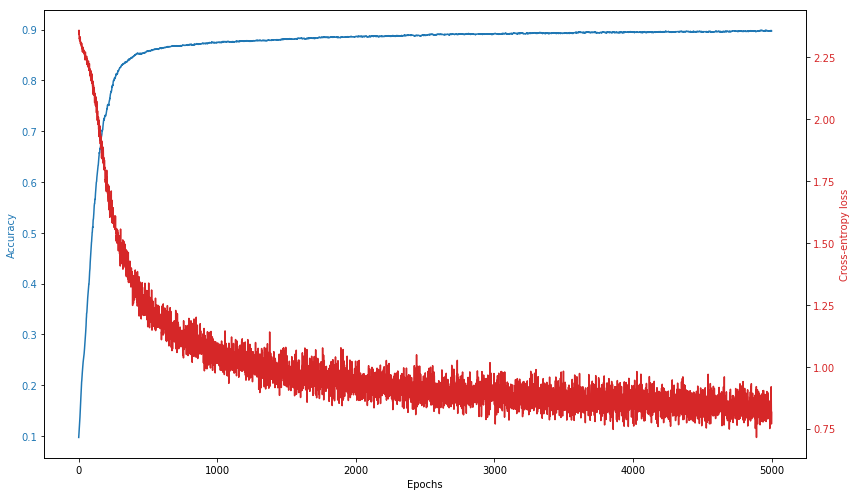

In [16]:
epochs = 5000
learning_rate = 0.03
beta_input = 0.01
batch_size = 1000

run_session(graph, epochs, learning_rate, beta_input, batch_size)